In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('data/insurance.zip')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:<br>
<br>
age — возраст основного бенефициара;<br>
sex — пол страхового подрядчика;<br>
bmi — индекс массы тела (кг/м2), в идеале — от 18.5 до 24.9;<br>
children — количество детей, охваченных медицинской страховкой;<br>
smoker — является ли человек курящим;<br>
region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);<br>
charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [3]:
print(data.shape)
# (1338, 7)

(1338, 7)


In [4]:
# Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Посмотрим на типы данных:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:<br>
<br>
age, bmi, children — числовые признаки;<br>
sex, smoker — бинарные категориальные переменные (две категории);<br>
region — множественные категориальные переменные (несколько категорий);<br>
charges — числовой целевой признак.

<i>Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:<br>
<br>
гистограммы/коробчатые диаграммы числовых признаков;<br>
столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;<br>
диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).</i>

#### гистограммы/коробчатые диаграммы числовых признаков

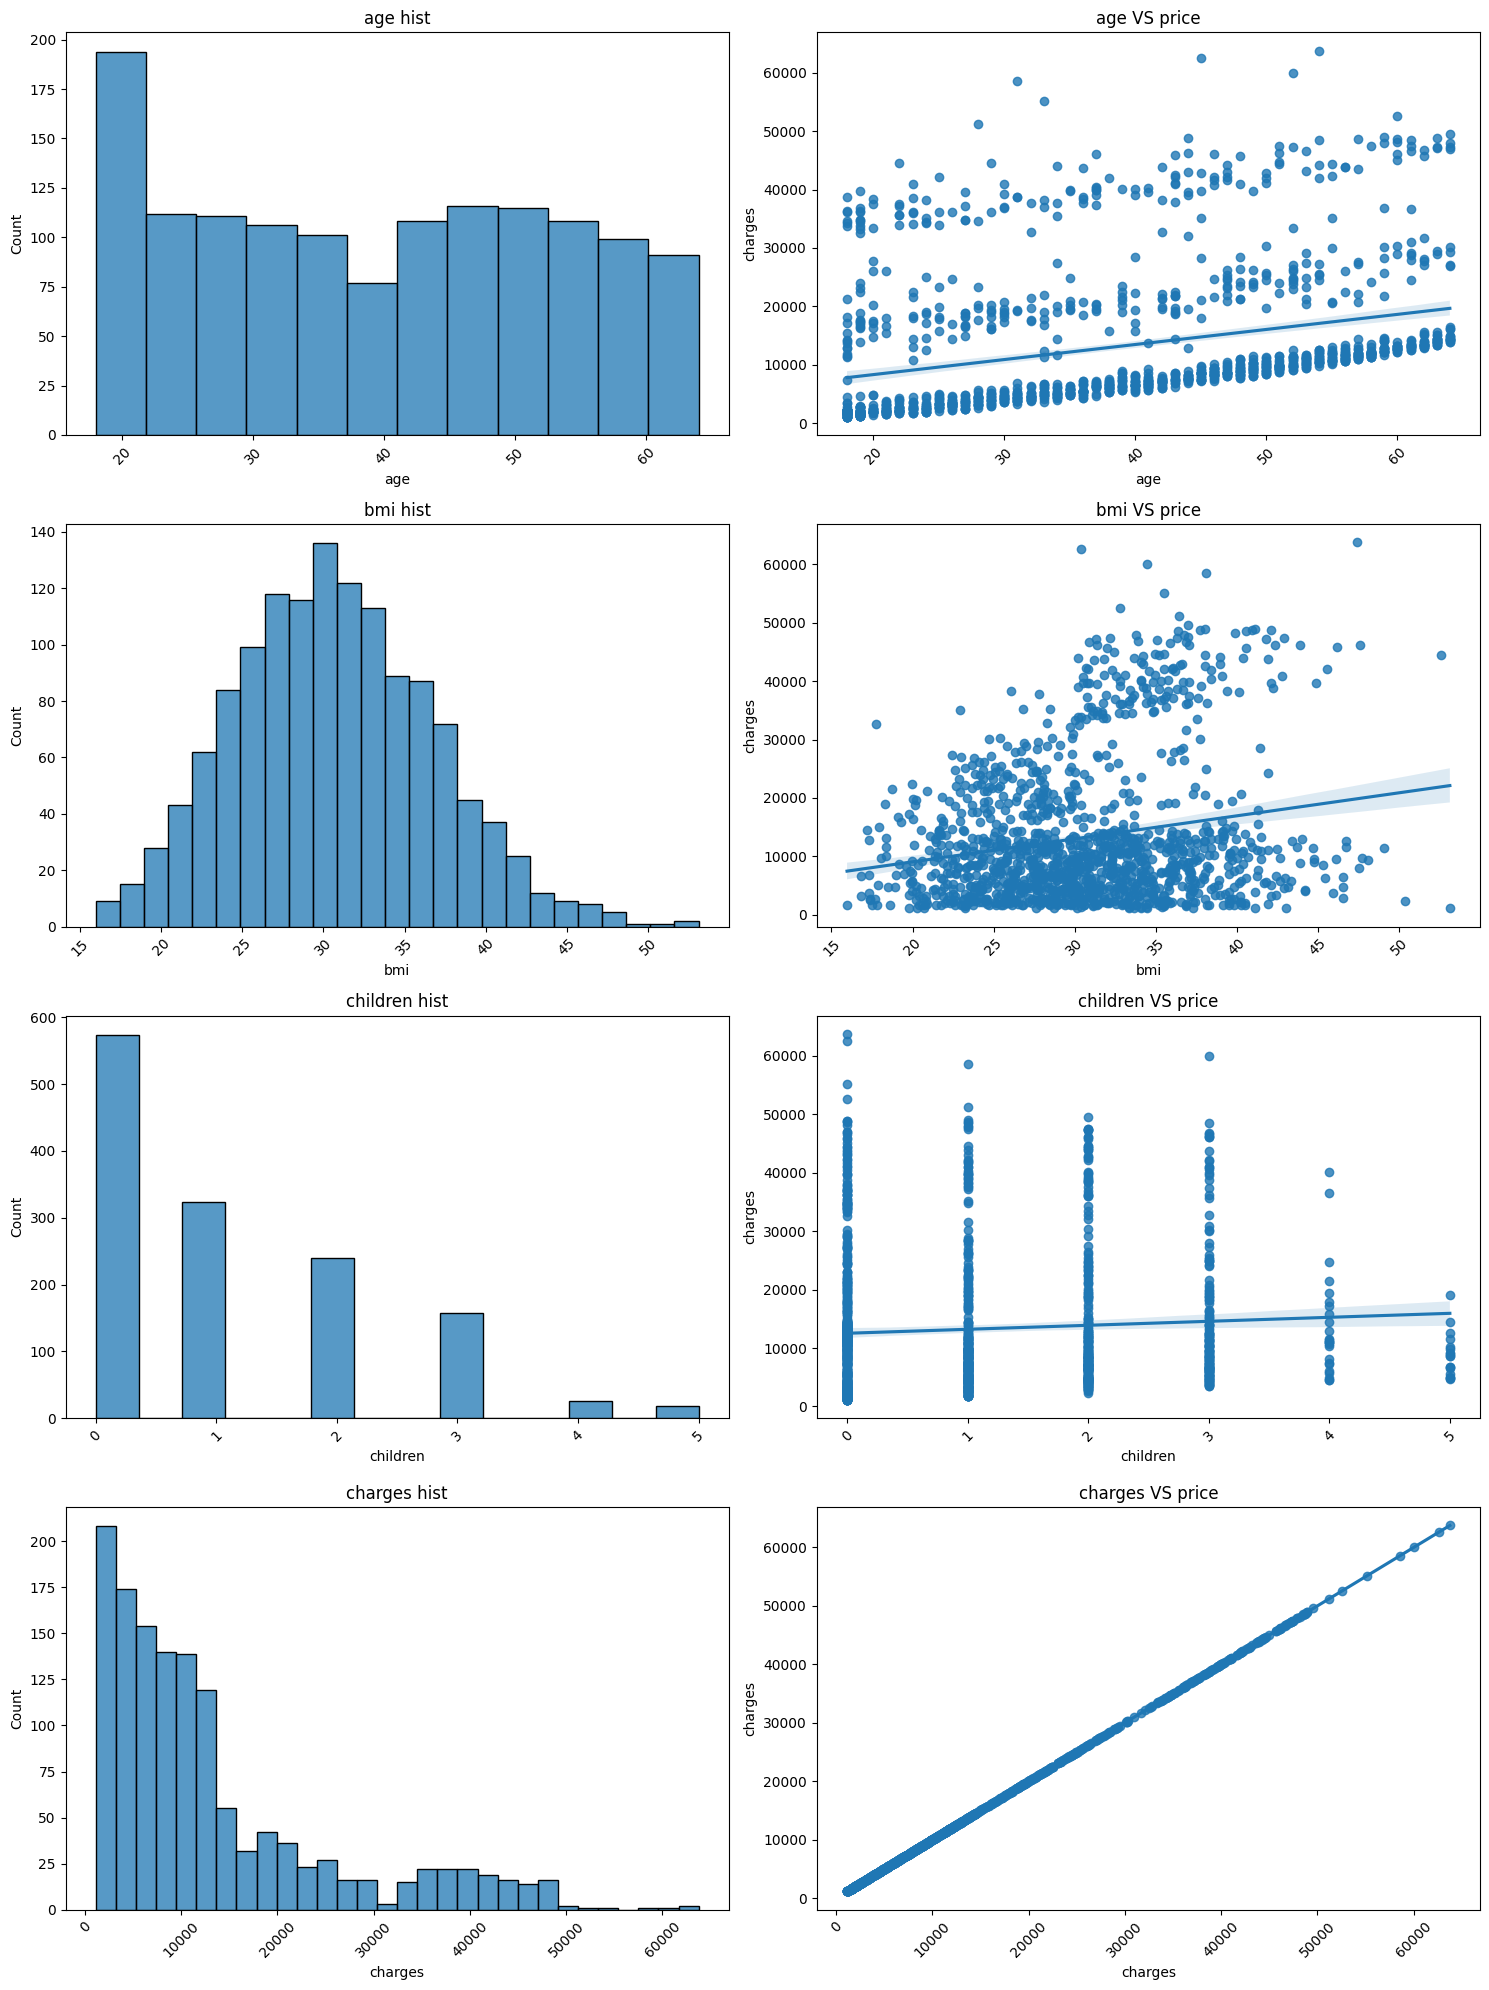

In [7]:
temp_data = data.copy()

types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)

n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

C:\Users\trigubov\AppData\Local\Temp\ipykernel_11496\282801187.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp_data.corr(), annot=True);


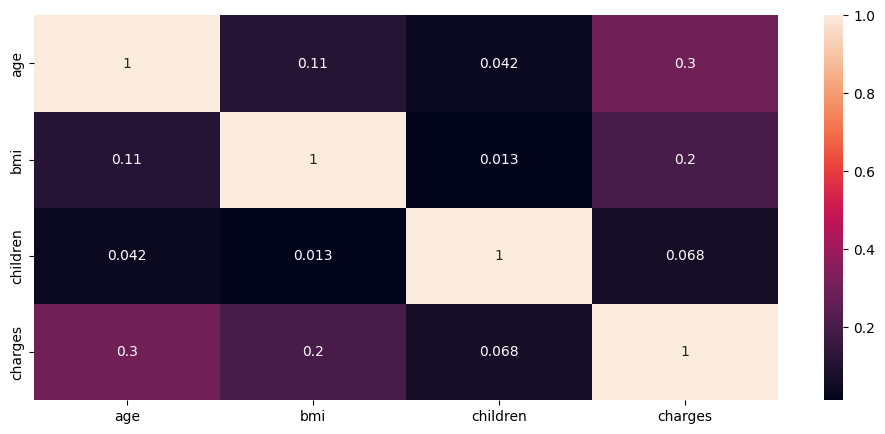

In [8]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(), annot=True);

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.<br>
<br>
Кодировку будем совершать по следующему принципу:<br>
<br>
smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);<br>
sex — аналогично (0 — female, 1 — male);<br>
region — используем OneHot-кодирование (воспользуемся функцией get_dummies).<br>

In [9]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Выделим факторы и целевой признак в отдельные таблицы:

In [10]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

### Задание 6.1

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

In [12]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


#### Задание 6.2 - 6.3

Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [13]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [14]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


In [17]:
print (round(lr.intercept_,2))

-12390.8


### Задание 6.4

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: y-y^ (без модуля).

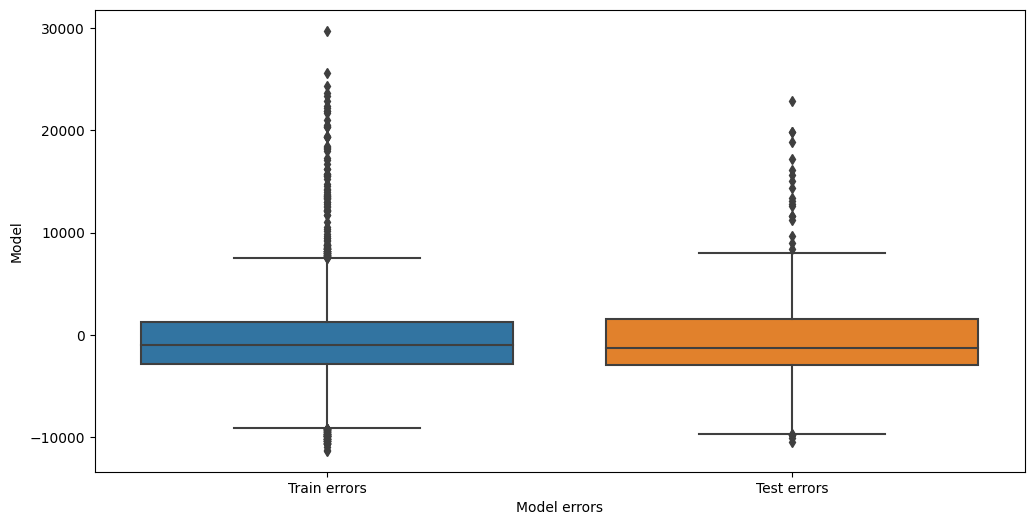

In [18]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

### Задание 6.5

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

<i>Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.</i>

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

Чему равно результирующее количество столбцов?

In [19]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


### Задание 6.6

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики  на тестовой выборке?

Значение R2 округлите до трёх знаков после запятой.

In [25]:
lr_poly = linear_model.LinearRegression()
#lr_poly.fit(X_train_scaled_poly, y_train_log)
lr_poly.fit(X_train_scaled_poly, y_train)
# Раз мы не используем логарифм целевого признака, то нам и экспонента не нужна
# y_train_pred = np.exp(lr_poly.predict(X_train_scaled_poly))
# y_test_pred = np.exp(lr_poly.predict(X_test_scaled_poly))
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2909.444
Train MAPE: 30.080


Test R^2: 0.866
Test MAE: 2761.826
Train MAPE: 31.149


### Задание 6.7

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

In [26]:
lr_poly.coef_

array([-2.33744037e+16,  1.80658975e+17,  6.54572599e+15,  8.19598379e+15,
       -1.28411613e+16, -5.41525215e+16, -1.86801231e+17, -5.16951569e+16,
       -2.99909056e+16,  8.77600000e+03,  9.56000000e+02,  1.15200000e+03,
       -1.67100000e+03,  1.84000000e+02,  2.33744037e+16,  2.33744037e+16,
        2.33744037e+16,  2.33744037e+16, -1.34963978e+17,  6.78625000e+02,
       -1.23575000e+03,  2.83625000e+02, -4.56949976e+16, -4.56949976e+16,
       -4.56949976e+16, -4.56949976e+16, -9.71131250e+03,  1.48968750e+03,
        5.47753594e+04, -6.54572599e+15, -6.54572599e+15, -6.54572599e+15,
       -6.54572599e+15, -2.04800000e+03, -2.22600000e+03, -8.19598379e+15,
       -8.19598379e+15, -8.19598379e+15, -8.19598379e+15, -5.85445639e+15,
        1.86956176e+16,  1.86956176e+16,  1.86956176e+16,  1.86956176e+16,
       -2.50483735e+16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.07600336e+17,  0.00000000e+00,  0.00000000e+00, -2.75057381e+16,
        0.00000000e+00, -

### Задание 6.8

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики R2 , MAE и MAPE на тестовой выборке?

In [28]:
#Инициализируем объект класса линейная регрессия с L1-регуляризацией 
max_iter=2000
lasso_lr_poly = linear_model.Lasso(max_iter=10000)
#Обучаем модель предсказывать логарифм целевого признака
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_pred = lasso_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


### Задание 6.9

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики R2 , MAE и MAPE на тестовой выборке?

In [29]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
#max_iter=2000
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
